# Multi-Level Driven Transmon

This notebook demonstrates the creation of a transmon and driving pulse, optimisation of pulse amplitude, frequency, and DRAG amplitude to perform a NOT gate, and examination of acceptable noise thresholds to retain fidelity above some threshold.

The driver Hamiltonian is proportional to $\hat{x}=a+a^\dag$, where these are the annihilation and creation operators. The system is also subject to decay (through the annihiliation operator) and dephasing (through the number operator, which is taken to be a projective measurement on the $z$ axis). By default, decay and decoherence are turned off by setting their respective characteristic times to infinity.

The transmon Hamiltonian is that of a Duffing oscillator and is taken from [qiskit](https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html#4.-The-Quantized-Transmon-).

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicHermiteSpline
import sympy
from mpl_toolkits import mplot3d
from copy import deepcopy

%matplotlib inline

In [2]:
# helper functions

# function to calculate transition frequency
def calculate_ω(transmon, n1, n2):
    return (transmon.Ω - 0.5*transmon.α) * np.abs(n2 - n1) + 0.5 * transmon.α * (n2**2 - n1**2)

# defines the letters used later as sympy symbols
x,A,ω,φ,y0,μ,Γ,M,A_DRAG = sympy.symbols("x,A,ω,φ,y0,μ,Γ,M,A_DRAG")

# window function for a Blackman pulse
# func is a sympy symbolic expression
def window(func):
    return sympy.Piecewise(
        (0, x>μ+M/2),
        (0, x<μ-M/2),
        (func, True)
    )

In [3]:
# shape functions

sinusoid_sym = A*sympy.cos(ω*x-φ)+y0

# CHECK THE SHIFTS FOR THE DRAG ADDITIONS
# for Gaussian it's pi/2, but for Blackman M/2 seems to work instead?

gaussian_sym = A*sympy.exp((-4*np.log(2)*((x-μ)**2))/(Γ**2))
gaussian_sym += A_DRAG * sympy.diff(gaussian_sym, x).subs(x, x-sympy.pi/2)

blackman_sym = A*(1-(0.42 - 0.5 * sympy.cos(2*sympy.pi*(x-μ)/M) + 0.08 * sympy.cos(4*sympy.pi*(x-μ)/M)))
blackman_sym = window(blackman_sym + A_DRAG * sympy.diff(blackman_sym, x).subs(x, x-M/2))

# converts the symbolic expressions to actual functions

sinusoid_func = sympy.lambdify([x,A,ω,φ,y0], sinusoid_sym, "numpy")
gaussian_func = sympy.lambdify([x,A,μ,Γ,A_DRAG], gaussian_sym, "numpy")
blackman_func = sympy.lambdify([x,A,μ,M,A_DRAG], blackman_sym, "numpy")

# sinusoid
def sinusoid(x_val,A_val,ω_val,φ_val,y0_val):
    return sinusoid_func(x_val,A_val,ω_val,φ_val,y0_val)

# gaussian
# not normalised
# Γ is FWHM
def gaussian(x_val,A_val,μ_val,Γ_val,A_DRAG_val=0):
    # the defaualt A_DRAG_val=0 is only for the optimum finding function, and must be specified for the actual pulse.
    return gaussian_func(x_val,A_val,μ_val,Γ_val,A_DRAG_val)

# blackman
# as defined on the numpy page
# Γ_val is the FWHM, while M is the Blackman parameter
def blackman(x_val,A_val,μ_val,Γ_val,A_DRAG_val): 
    M_val = Γ_val / 0.810957 # conversion from FWHM to Blackman parameter
    return blackman_func(x_val,A_val,μ_val,M_val,A_DRAG_val)

In [4]:
# Transmon class
# Initialises a transmon given
# * number of energy levels
# * initial energy level
# * n=0 to n=1 transition frequency and anharmonicity
# * decay and dephasing times
# * whether to use the rotating wave approximation
# Calculates the collapse and expected-value operators during initialisation
# Note Ω and α can be derived from the physical parameters Ec (charging energy) and Ej (Josephson energy) using
#   α = -Ec
#   Ω = sqrt(8*Ec*Ej)-Ec

class transmon:

    def __init__(self, n_levels:int, initial_level:int, Ω:float=5000, α:float=-350, t_decay:float=np.inf, t_dephase:float=np.inf,  RWA=True):
        
        self.n_levels = n_levels
        self.initial_level = initial_level
        self.ψ0 = basis(n_levels,initial_level)

        self.α = α # anharmonicity
        self.Ω = Ω # n=0 to n=1 transition frequency

        self.t_decay = t_decay
        self.t_dephase = t_dephase

        self.a = destroy(n_levels) # annihiliation operator
        self.n = self.a.dag() * self.a # number operator

        if RWA:
            self.H0 = self.n*self.Ω + 0.5 * α * self.n * (self.n-1)
        else:
            self.H0 = (self.Ω-self.α)*(self.n+0.5) + ((self.Ω-self.α)**2)/(8*self.α) + (self.α*(self.a+self.a.dag())**4)/12 # worth going to higher order terms?

        self.c_ops = self.__make_cops__()
        self.e_ops = self.__make_eops__()

    def __make_cops__(self):
        decay = np.sqrt(1/self.t_decay) * self.a

        # The first one below is the one used by the previous master's student, but I'm not sure why that particular combination of times is applied
        # decohere = np.sqrt(1/self.t_dephase-0.5/self.t_decay) * self.n
        decohere = np.sqrt(1/self.t_dephase) * self.n

        return [decay, decohere]

    def __make_eops__(self):
        # returns the operator for the energy level n

        def level_operator(n):
            return basis(self.n_levels, n) * basis(self.n_levels, n).dag()

        return [level_operator(i) for i in range(0, self.n_levels)]

    def info(self):
        print ("Transmon:")
        print (" - No of levels: " + str(self.n_levels))
        print (" - Initial level: " + str(self.initial_level))
        print (" - Frequency: " + str(self.Ω))
        print (" - Anharmonicity: " + str(self.α))
        print (" - Decay time: " + str(self.t_decay))
        print (" - Dephase time: " + str(self.t_dephase))

In [5]:
# Driving pulse class
# Forms a driving pulse givem
# * the transmon to be acted on
# * the envelope function ("gaussian" or "blackman")
# * the initial level of the transmon
# * the target level of the transmon
# During creation, sets up the driving Hamiltonian

class driver:

    def __init__(self, transmon, pulse_func, initial_level, target_level):

        self.transmon = transmon
        self.n1 = initial_level
        self.n2 = target_level
        self.ω = calculate_ω(transmon, self.n1, self.n2) # calculate the theoretical optimal driving frequency

        try:
            self.pulse_func = pulse_func.lower() # envelope function
        except:
            raise TypeError("pulse_func must be a str. Modify the driver class cell to alter this.")

        # edit this to allow two-level transitions as well
        # self.H1 = transmon.a + transmon.a.dag() + transmon.a**2 + transmon.a.dag()**2
        self.H1 = transmon.a + transmon.a.dag() # transition operator
        self.H1_coeffs = self.__make_H1_coeffs__()

    def __make_H1_coeffs__(self):

        if "gaussian" in self.pulse_func:
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args.values()
                return sinusoid(t,1,ω,ω*μ,0) * gaussian(t,A,μ,Γ,A_DRAG)

        elif "blackman" in self.pulse_func:
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args.values()
                return sinusoid(t,1,ω,ω*μ,0) * blackman(t,A,μ,Γ,A_DRAG)

        else:
            raise ValueError("pulse_func must be either gaussian or blackman.")

            # this may be included to allow custom functions to be passed
            # def H1_coeffs(t, args):
            #     return self.pulse_func(t,args)
                
        return H1_coeffs

    def info(self):
        print ("Driver pulse:")
        print (" - Pulse type: " + self.pulse_func)
        print (" - Initial level: " + str(self.n1))
        print (" - Target level: " + str(self.n2))
        print (" - Frequency: " + str(self.ω))

    def visualise(self, t, args):
        plt.figure()
        plt.plot(t, self.H1_coeffs(t, args))
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()

    # function to find the optimal value of some parameter to reach the target level
    # takes
    # * times (list)
    # * pulse arguments
    # * which parameter to vary
    # * semirange over which to vary
    # * whether to plot the fitting function
    # * whether to return the fidelity function only or find the optimal value
    # Calculates the fidelity for each parameter value and finds the maximum
    # Outputs the optimal value and the associated curve
    def optimize_parameter(self, t:list, args:dict, parameter:str, semirange:float, plot=False, fidelity_only=False, N=51):

        # pre-checks
        if parameter not in ["A", "ω", "Γ", "A_DRAG"]:
            raise ValueError("parameter must be amplitude A, frequency ω, width Γ, or DRAG amplitude A_DRAG.")
        
        # this is essential, otherwise the variable is modified outside the function
        args_tmp = deepcopy(args)        

        H = [self.transmon.H0, [self.H1, self.H1_coeffs]]
        test_values = np.linspace(args[parameter]-semirange, args[parameter]+semirange, N)

        fidelity = []

        # for each possible value, find the probabilities of being in each level at the end of the pulse
        for i in test_values:
            args_tmp[parameter] = i
            ψt = mesolve(H, self.transmon.ψ0, t, self.transmon.c_ops, [self.transmon.e_ops[self.n2]], args_tmp)
            fidelity.append(ψt.expect[0][-1])

        # the fidelity curve
        fidelity_func = CubicHermiteSpline(test_values, fidelity, np.gradient(fidelity, test_values))

        if fidelity_only:
            return fidelity_func

        # fit the appropriate curve to each plot and find the optimal value
        if parameter == "A":

            # perform a fourier transform to find the initial frequency guess
            freqs = np.fft.fftfreq(N, (test_values[1]-test_values[0]))*2*np.pi
            Fy = abs(np.fft.fft(fidelity))
            A_guess = np.std(fidelity) * np.sqrt(2)
            ω_guess = abs(freqs[np.argmax(Fy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
            φ_guess = np.pi
            y0_guess = np.mean(fidelity)
            p0 = [A_guess, ω_guess, φ_guess, y0_guess]
  
            # NOTE we are varying amplitude of the driving pulse. The below sinusoid parameters are those of the fitting function, not the pulse
            A,ω,φ,y0 = curve_fit(sinusoid, test_values, fidelity, p0=p0, bounds=([0,0,0,0],[1,np.inf,np.inf,2]))[0]
            # calculate R² value of fit
            r2 = 1-(np.sum((fidelity- sinusoid(test_values,A,ω,φ,y0))**2)/np.sum((fidelity-np.mean(fidelity))**2))
            
            # if the fit is good enough, calculates optimal from fitted sinusoid
            if r2 > 0.95:
                optimal_value = φ/ω
                while optimal_value < test_values[0]:
                    optimal_value += 2*np.pi/ω
                while optimal_value > test_values[-1]:
                    optimal_value -= 2*np.pi/ω

        elif parameter == "ω":
            # fit a gaussian
            A,μ,Γ = curve_fit(gaussian, test_values, fidelity, p0=[0.5, args["ω"], 200], bounds=([0,0,1],[1,np.inf,np.inf]))[0]
            # calculate R² value of fit
            r2 = 1-(np.sum((fidelity- gaussian(test_values,A,μ,Γ))**2)/np.sum((fidelity-np.mean(fidelity))**2))
            # if the fit is good enough, the optimal value is the mean of the gaussian
            if r2 > 0.95:
                optimal_value = μ
        
        elif parameter == "Γ":
            # what should this be?

            raise NotImplementedError("This is not implemented yet.")

        elif parameter == "A_DRAG":
            # no default shape so the spline is directly used
            r2=0

        # if none of the fits are good enough, uses simple maximum of spline
        if r2 < 0.95:
            cr_pts = fidelity_func.derivative().roots()
            max_index = np.argmax(fidelity_func(cr_pts))

            # SHOULD THIS BE THE OTHER WAY AROUND?
            if fidelity_func(cr_pts[max_index]) > max(fidelity):
                optimal_value = cr_pts[max_index]
            else:
                optimal_value = test_values[np.argmax(fidelity)]
                
        fitted_x = np.linspace(test_values[0], test_values[-1], 500)
        fitted_y = fidelity_func(fitted_x)

        print("Optimal " + parameter + ": " + str(optimal_value) + " with fidelity " + str(fidelity_func(optimal_value)))
        args[parameter] = optimal_value
        
        if plot:
            plt.plot(test_values, fidelity, 'x')
            plt.plot(fitted_x, fitted_y)
            plt.legend(["n="+str(self.n2), "Fitted"])
            plt.xlabel(parameter)
            plt.ylabel("Probability")
            plt.axvline(optimal_value, color='r')
            plt.title("Optimal " + parameter + " for n="+str(self.n1)+" to "+str(self.n2))
            plt.show()

        return args, fidelity_func

    def optimise(self, t:list, args:dict, plot=False):

        print("Round 1/4...")
        args, _ = self.optimize_parameter(t, args, "A", 200, plot)
        args, _ = self.optimize_parameter(t, args, "ω", 200, plot)
        args, _ = self.optimize_parameter(t, args, "A_DRAG", 0.15, plot)

        print("Round 2/4...")
        args, _ = self.optimize_parameter(t, args, "ω", 50, plot)
        args, _ = self.optimize_parameter(t, args, "A", 100, plot)
        args, _ = self.optimize_parameter(t, args, "A_DRAG", 0.05, plot)
        
        print("Round 3/4...")
        args, _ = self.optimize_parameter(t, args, "A", 30, plot)
        args, _ = self.optimize_parameter(t, args, "ω", 10, plot) 
        args, _ = self.optimize_parameter(t, args, "A_DRAG", 0.02, plot)

        print("Round 4/4...")
        args, _ = self.optimize_parameter(t, args, "A", 20, plot)
        args, _ = self.optimize_parameter(t, args, "ω", 10, plot)
        args, _ = self.optimize_parameter(t, args, "A_DRAG", 0.01, plot)

        print("Calculating fidelity function for A...")
        A_fidelity = self.optimize_parameter(t, args, "A", 30, plot, True)
        print("Calculating fidelity function for ω...")
        ω_fidelity = self.optimize_parameter(t, args, "ω", 100, plot, True)
        print("Calculating fidelity function for A_DRAG...")
        A_DRAG_fidelity = self.optimize_parameter(t, args, "A_DRAG", 0.1, plot, True)
        print("Done!")

        return args, A_fidelity, ω_fidelity, A_DRAG_fidelity

    # the below is another way to find the optimal value, by creating a 3D array of the test values and evaluating the fidelity at each
    # it takes very long to run and returns slightly different results
    # i've decided to stick with the above for now

    def fidelity(self, t, args):
        H = [self.transmon.H0, [self.H1, self.H1_coeffs]]
        ψt = mesolve(H, self.transmon.ψ0, t, self.transmon.c_ops, [self.transmon.e_ops[self.n2]], args)
        return ψt.expect[0][-1]

    def optimise_v2(self, t, args, args_semiranges, plot=False):

        A_range = np.linspace(args["A"]-args_semiranges["A"], args["A"]+args_semiranges["A"], 10)
        ω_range = np.linspace(args["ω"]-args_semiranges["ω"], args["ω"]+args_semiranges["ω"], 10)
        A_DRAG_range = np.linspace(args["A_DRAG"]-args_semiranges["A_DRAG"], args["A_DRAG"]+args_semiranges["A_DRAG"], 10)

        fidelities = np.zeros((10, 10, 10))

        for Ai, A in enumerate(A_range):
            for ωi, ω in enumerate(ω_range):
                for A_DRAG_i, A_DRAG in enumerate(A_DRAG_range):
                    args["A"] = A
                    args["ω"] = ω
                    args["A_DRAG"] = A_DRAG

                    fidelities[Ai][ωi][A_DRAG_i] = self.fidelity(t, args)

        max_fidelity = np.max(fidelities)
        ind = np.unravel_index(np.argmax(fidelities), fidelities.shape)
        optima = [A_range[ind[0]], ω_range[ind[1]], A_DRAG_range[ind[2]]]

        if plot:
            try:
                fig=plt.figure(0)
                ax = plt.subplot(projection='3d')

                grid = np.meshgrid(A_DRAG_range, ω_range, A_range)

                x = ax.scatter(*grid, c=fidelities)
                plt.colorbar(x)
                plt.show()

                f1, ax = plt.subplots(1, 3, sharey=True)
                grid = np.meshgrid(ω_range, A_DRAG_range)
                ax[0].plot(A_range, fidelities[:][ind[1]][ind[2]])
                ax[1].plot(ω_range, fidelities[ind[0]][:][ind[2]])
                ax[2].plot(A_DRAG_range, fidelities[ind[0]][ind[1]][:])
                plt.show()
            except:
                pass

        return fidelities, max_fidelity, optima

In [6]:
# Propagation function
# Takes
# * a transmon
# * a driver pulse
# * a list of times
# * parameters for the driver pulse
# Propagates them forward in time with qutip mesolve, and plots the probability of the transmon being in each energy level as a function of time.
# Also returns a bar chart with the final probability of each level

def propagate(transmon, driver, t, args):

    H = [transmon.H0, [driver.H1, driver.H1_coeffs]]

    ψt = mesolve(H, transmon.ψ0, t, transmon.c_ops, transmon.e_ops, args)

    plt.figure()
    [plt.plot(t, i) for i in ψt.expect]
    plt.legend(["n="+str(i) for i in range(0, len(ψt.expect))])
    plt.xlabel("Time [s]")
    plt.ylabel("Probability")
    plt.title(", ".join([i + ": " + str(round(args[i],5)) for i in args])) # slicing to get rid of {} in output
    plt.show()

    _, ax = plt.subplots()
    dat = ax.bar([i for i in range(len(ψt.expect))], [round(i[-1], 5) for i in ψt.expect])
    ax.bar_label(dat)
    plt.xticks([i for i in range(len(ψt.expect))], ["n="+str(i) for i in range(len(ψt.expect))])
    plt.title("Final level probabilities")
    plt.xlabel("Energy level")
    plt.ylabel("Probability")
    plt.show()

In [7]:
# this function calculates how noise in one of the pulse parameters affects the fidelity
# takes
# * the optimal value of the parameter
# * the fidelity function, a spline
# * the maximum amount of noise to add (maximum stdev of the gaussian distribution used to model noise added to the parameter)
# * minimum acceptable fidelity

def noise_effects(parameter:float, fidelity_func, max_noise:float, fidelity_threshold:float):

    noise_σs = np.linspace(0, max_noise, 500)
    fidelities = []

    # for each value of noise, create an array with that much noise around the optimal value, and calculate the average fidelity
    for σ in noise_σs:
        noisy_values = parameter + np.random.normal(0, σ, 2000)
        fidelities.append(np.average(fidelity_func(noisy_values)))

    # calculate the maximum noise threshold to achieve some fidelity
    try:
        max_noise_threshold = noise_σs[np.where(np.array(fidelities)>=fidelity_threshold)[0][-1]]
    except Exception as e:
        raise RuntimeError("The desired fidelity is never achieved. Try re-running optimisation.") from e

    print("Max noise threshold to achieve " + str(fidelity_threshold) + " fidelity is σ = " + str(max_noise_threshold) + ". ")

    plt.plot(noise_σs, fidelities)
    plt.axhline(fidelity_threshold)
    plt.axvline(max_noise_threshold)
    plt.ylabel("Fidelity")
    plt.xlabel("Amplitude noise [σ]")
    plt.ylim(2*fidelity_threshold-1, 1)
    plt.title("Fidelity variation")
    plt.show()

In [8]:
# set up transmon and driver
tr = transmon(n_levels=3, initial_level=0, Ω=5925, α=-243, t_decay=1000, t_dephase=1000, RWA=False)
d = driver(tr, "blackman", initial_level=0, target_level=1)

args = {"A":90, "μ":0.04, "Γ":0.05, "ω":d.ω, "A_DRAG":0.01}

t = np.linspace(0, 0.1, 1000)

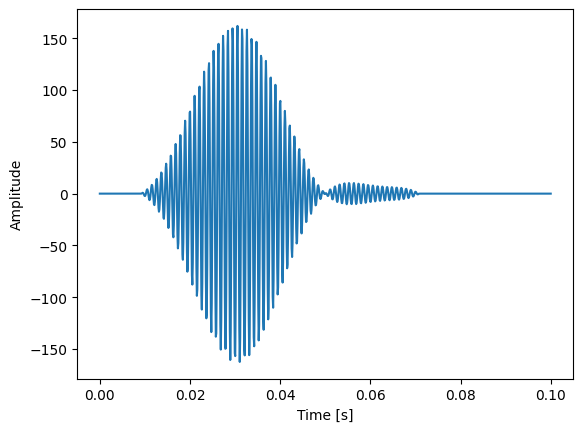

In [17]:
d.visualise(t, args)

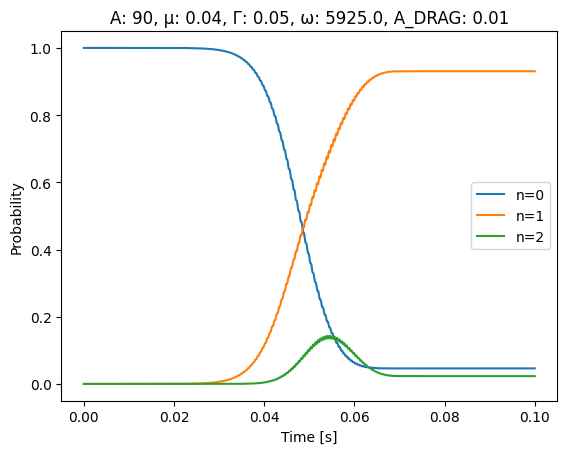

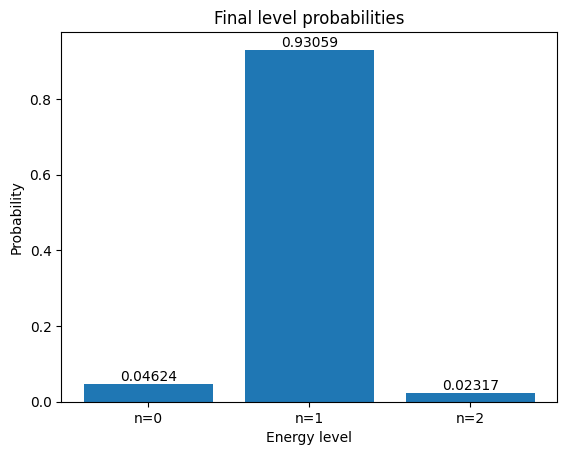

In [9]:
propagate(tr, d, t, args)

In [10]:
args, A_fidelity, ω_fidelity, A_DRAG_fidelity = d.optimise(t, args, False)

Round 1/4...
Optimal A: 93.24652262613141 with fidelity 0.9249700399838738
Optimal ω: 5953.447439626222 with fidelity 0.9877274537627603
Optimal A_DRAG: -0.013433982020648851 with fidelity 0.9937063489854092
Round 2/4...
Optimal ω: 5956.677833855594 with fidelity 0.9945093669763863
Optimal A: 93.63191829293064 with fidelity 0.9943640607487115
Optimal A_DRAG: -0.014132959047924833 with fidelity 0.994749445153987
Round 3/4...
Optimal A: 92.66275846008992 with fidelity 0.9950813081201471
Optimal ω: 5958.226118162019 with fidelity 0.9952743928280711
Optimal A_DRAG: -0.014678774098832012 with fidelity 0.9955277220597668
Round 4/4...
Optimal A: 92.5770173502033 with fidelity 0.9955352862537243
Optimal ω: 5959.9966789676455 with fidelity 0.995775842302024
Optimal A_DRAG: -0.015156637807824336 with fidelity 0.9959882729267501
Calculating fidelity function for A...
Calculating fidelity function for ω...
Calculating fidelity function for A_DRAG...
Done!


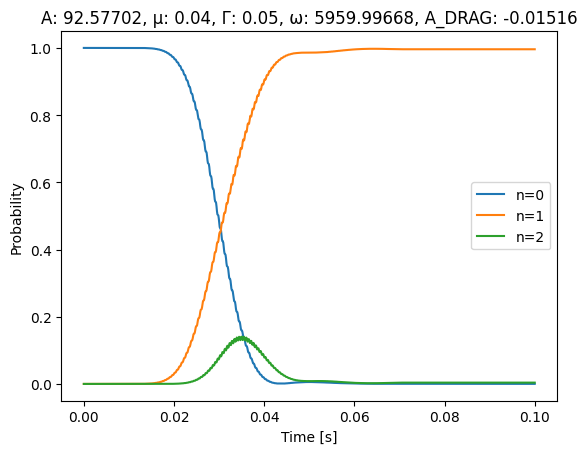

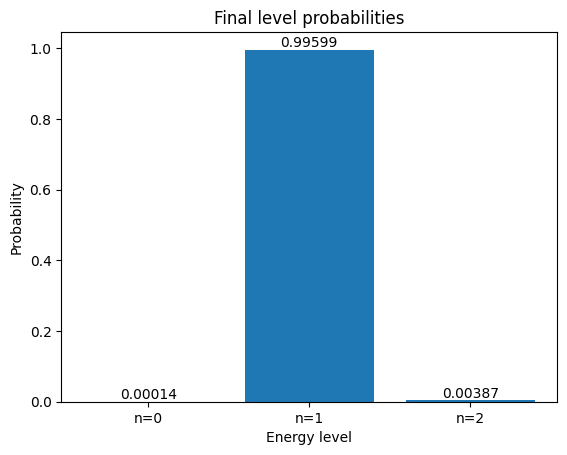

In [11]:
propagate(tr, d, t, args)

Max noise threshold to achieve 0.99 fidelity is σ = 4.909819639278557. 


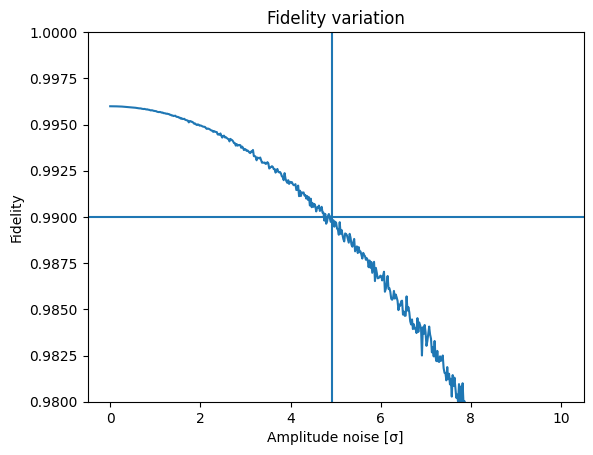

In [12]:
noise_effects(args["A"], A_fidelity, 10, 0.99)

Max noise threshold to achieve 0.99 fidelity is σ = 9.438877755511022. 


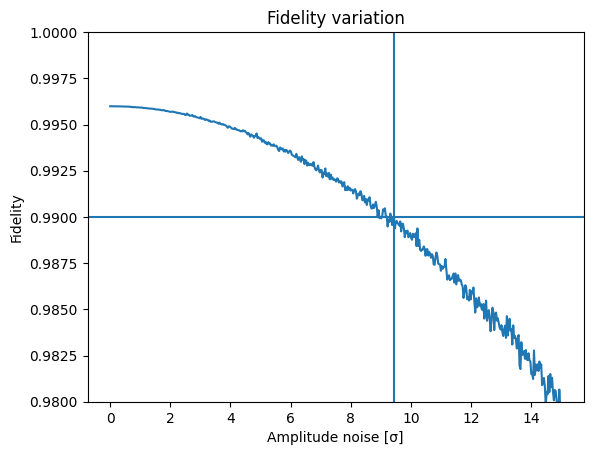

In [13]:
noise_effects(args["ω"], ω_fidelity, 15, 0.99)

Max noise threshold to achieve 0.99 fidelity is σ = 0.002597194388777555. 


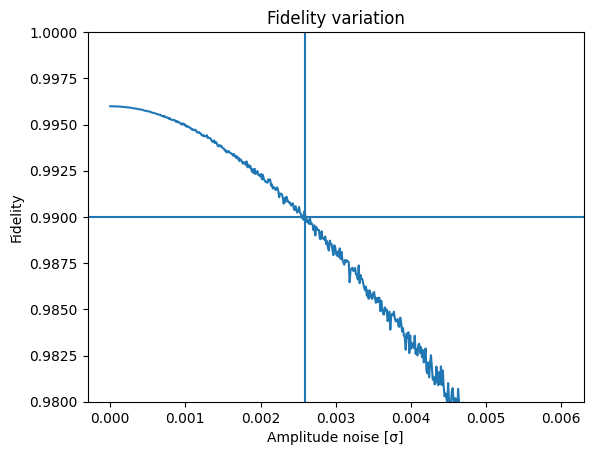

In [14]:
noise_effects(args["A_DRAG"], A_DRAG_fidelity, 0.006, 0.99)

In [15]:
# args_semiranges = {"A": 10, "ω":20, "A_DRAG": 0.01}
# fidelities, max_fidelity, optima = d.optimise_v2(t, args, args_semiranges, True)
# print(max_fidelity, optima)